In [1]:
import os
import platform
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Normalize correlator at t=0 t0 1? 

In [2]:
beta=4.03
ml=0.1
mh=0.2

NT=64

ncstart=200
ncfinish=2200
step=5
NCFG=(ncfinish-ncstart)/step

def mesonDatasetToNumpy(dataset):
    data = dataset['corr']
    arr = []
    for elem in data:
        arr.append(complex(elem[0],elem[1]))
    return np.array(arr)

In [3]:
userDir=os.path.expanduser('~')
dataDir=''

dataDir=os.path.join(userDir,'Documents','LatticeQCD','PIPI','b{}_ml{}_mh{}'.format(beta,ml,mh))

pionDir=os.path.join(dataDir,'mesons')

In [4]:
pionCorrs={}
sourceTimes=[i for i in range(0,64,8)]
for tsource in sourceTimes:

    corrs=[]
    for cfg in range(ncstart, ncfinish, step):
        fileName=os.path.join(pionDir,'wall_ll.t{}.{}.h5'.format(tsource,cfg))
        file = h5py.File(fileName,'r')
        meson0=file['meson']['meson_0']
        corr = mesonDatasetToNumpy(meson0)
        corr = np.roll(corr, -tsource)
        corrs.append(corr)

    pionCorrs[tsource]=np.asarray(corrs)

In [45]:
avgPionCorr=pionCorrs[sourceTimes[1]]
for t0 in sourceTimes[2:]:
    avgPionCorr+=pionCorrs[t0]
avgPionCorr=avgPionCorr/len(sourceTimes)

avgPionCorr=np.array([foldCorr(c) for c in avgPionCorr])

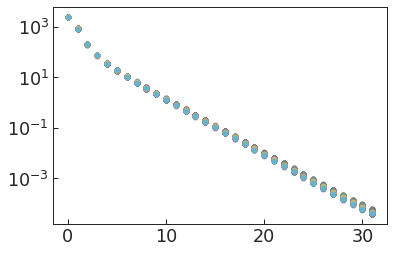

In [46]:
plt.yscale('log')
for corr in avgPionCorr:
    plt.plot(np.real(corr),linestyle="",marker="o")
plt.show()

In [47]:
np.shape(avgPionCorr)

(400, 32)

In [48]:
from jk import *
from utils import *

effMass=jackKnife(log_effective_mass,avgPionCorr)

/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  res.append(math.log(avg[t]/avg[t+1]))


(0.49, 0.505)

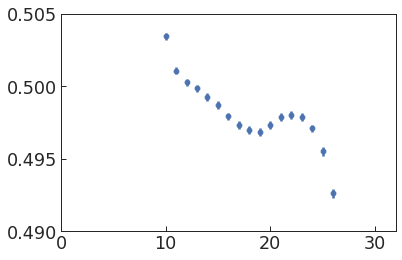

In [49]:
import matplotlib.pyplot as plt 

plt.errorbar([t for t in range(len(effMass[0]))], effMass[0].real, yerr=effMass[1].real,
    linestyle="None", marker="o")
plt.xlim(0,32)
plt.ylim(0.49,0.505)

In [51]:
import lsqfit
from model_avg_paper import *
from model_avg_paper.test_tmin import test_vary_tmin_SE
import gvar as gv

In [52]:
data = {'t': np.asarray([t for t in range(int(NT/2))]), 'ND': NCFG, 'yraw': np.real(avgPionCorr[:,0:int(NT/2)])}
data['y']=gv.dataset.avg_data(data['yraw'], bstrap=True)

In [53]:
def multi_exp_model(t, p, Nexc=2):
    ans = 0.0
    for i in range(0, Nexc):
        ans += p["A{}".format(i)] * np.exp(-p["E{}".format(i)] * t)
    return ans

In [73]:
fit_model = lambda t,p : multi_exp_model(t,p,1)
priors = {
    "A0": gv.gvar("1(1)"),
    "E0": gv.gvar("0.5(1)"),
    #"A1": gv.gvar("0.1(10)"),
    #"E1": gv.gvar("2(1)"),
    #"A2": gv.gvar("0.001(10)"),
    #"E2": gv.gvar("0.2(5)")
}

p0 = {
    "A0": 1, "E0": 0.5,
    #"A1": 0.1, "E1": 1.5,
    #"A2": 0.0001, "E2": 0.1
}

minChi2=1e10
bestFit=None
for ti in range(7,19):
    for tf in range(20,26):
        if tf-ti > 2:
            fitres1=lsqfit.nonlinear_fit(
                data=(data['t'][ti:tf], data['y'][ti:tf]),
                fcn = fit_model, 
                p0=p0
            )

            if fitres1.chi2<minChi2:
                minChi2=fitres1.chi2
                bestFit=fitres1

In [74]:
minChi2

0.005165150395868213

In [75]:
bestFit.p

BufferDict({'A0': 232(77), 'E0': 0.501(20)})

In [76]:
bestFit.dof

1

## Individual Source Times

In [62]:
for t0 in sourceTimes:
    data = {'t': np.asarray([t for t in range(int(NT/2))]), 'ND': NCFG, 'yraw': np.real(pionCorrs[t0][:,0:int(NT/2)])}
    data['y']=gv.dataset.avg_data(data['yraw'], bstrap=True)

    fit_model = lambda t,p : multi_exp_model(t,p,1)
    priors = {
        "A0": gv.gvar("1(1)"),
        "E0": gv.gvar("0.5(1)"),
        #"A1": gv.gvar("0.1(10)"),
        #"E1": gv.gvar("2(1)"),
        #"A2": gv.gvar("0.001(10)"),
        #"E2": gv.gvar("0.2(5)")
    }
    p0 = { "A0": 1, "E0": 0.5 }

    minChi2=1e10
    bestFit=None
    for ti in range(7,19):
        for tf in range(20,26):
            if tf-ti > 2:
                fitres1=lsqfit.nonlinear_fit(
                    data=(data['t'][ti:tf], data['y'][ti:tf]),
                    fcn = fit_model, 
                    #prior=priors
                    p0=p0
                )

                if fitres1.chi2<minChi2:
                    minChi2=fitres1.chi2
                    bestFit=fitres1
    
    print("t0={}, minChi2={}, dof={}, params={}, ti={}, tf={}".format(t0, minChi2, bestFit.dof, bestFit.p, bestFit.x[0], bestFit.x[len(bestFit.x)-1]))

t0=0, minChi2=0.09220037611895895, dof=1, params={'A0': 3296(368), 'E0': 0.4977(70)}, ti=17, tf=19
t0=8, minChi2=0.006134035083877096, dof=1, params={'A0': 1534(187), 'E0': 0.4974(70)}, ti=18, tf=20
t0=16, minChi2=0.021339713873882695, dof=1, params={'A0': 221(71), 'E0': 0.496(18)}, ti=17, tf=19
t0=24, minChi2=0.32154926206110457, dof=1, params={'A0': 193(60), 'E0': 0.490(16)}, ti=17, tf=19
t0=32, minChi2=0.0012921828089686252, dof=1, params={'A0': 218(72), 'E0': 0.497(21)}, ti=17, tf=19
t0=40, minChi2=4.163210240931956e-06, dof=1, params={'A0': 209(71), 'E0': 0.495(16)}, ti=18, tf=20
t0=48, minChi2=0.015381142678502362, dof=1, params={'A0': 231(74), 'E0': 0.501(18)}, ti=18, tf=20
t0=56, minChi2=0.005165150395868213, dof=1, params={'A0': 232(77), 'E0': 0.501(20)}, ti=18, tf=20
